In [1]:
import ray
GPU_UTILIZATION = 0.0
ray.init(num_gpus=GPU_UTILIZATION)

2023-11-22 20:45:23,883	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-22 20:45:25,726	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [39]:
import torch
import torch.nn as nn

from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

class CustomTorchModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(
            self,obs_space=obs_space, action_space=action_space, num_outputs=num_outputs, model_config=model_config, name=name
        )
        nn.Module.__init__(self)
        self.l10 = nn.Linear(obs_space.shape[0], 64)
        self.l11 = nn.Linear(64, 2)
        self.l20 = nn.Linear(2, 32)
        self.l21 = nn.Linear(32, 1)
        self.act = nn.ReLU()
    def forward(self, input_dict, state, seq_lens):
        x = self.act(self.l10(input_dict["obs"]))
        x = self.act(self.l11(x))
        self.value_out = self.l21(self.act(self.l20(x)))
        return x, state
    def value_function(self):
        return self.value_out[0]

ModelCatalog.register_custom_model("my_torch_model", CustomTorchModel)

In [40]:
from ray.rllib.algorithms.ppo import PPOConfig

config = PPOConfig().training(_enable_learner_api=False, model = {"custom_model":"my_torch_model"}, gamma=0.9, lr=0.0001, train_batch_size=512, sgd_minibatch_size=256)
config = config.rl_module(_enable_rl_module_api=False)
config = config.resources(num_gpus=GPU_UTILIZATION, num_learner_workers=1, num_gpus_per_worker=0, num_gpus_per_learner_worker=GPU_UTILIZATION)
config = config.rollouts(num_rollout_workers=4,create_env_on_local_worker=True)
config = config.framework("torch")

algo = config.build(env="CartPole-v1")  

(RolloutWorker pid=19301) 2023-11-22 23:07:15,924	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=19301) No CUDA runtime is found, using CUDA_HOME='/home/przemek/miniconda3/envs/ray_projects'
(RolloutWorker pid=19301) /home/przemek/miniconda3/envs/ray_projects/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_validation.py:114: UserWarning: WARNING: failed to get cudart_version from onnxruntime build info.
(RolloutWorker pid=19301)   warnings.warn("WARNING: failed to get cudart_version from onnxr

In [47]:
from time import time 
init_eval = algo.evaluate()

t1 = time()
for i in range(256):
    print(i,end='\r')
    algo.train()

print(time() - t1)
post_eval = algo.evaluate()

69.96879959106445


In [48]:
print('Mean reward per episode')
print('Before training: ',init_eval['evaluation']['episode_reward_mean'])
print('After training: ',post_eval['evaluation']['episode_reward_mean'])

Mean reward per episode
Before training:  21.406779661016948
After training:  32.94736842105263


In [43]:
import gymnasium as gym 
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [49]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
model = algo.get_policy().model

In [50]:
env.observation_space.shape[0]

4

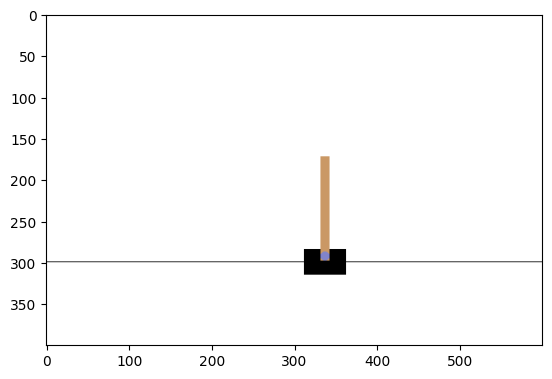

In [51]:
initial_state = env.reset()
num_steps=100
next_state = env.reset()[0]

for step in range(num_steps):
    with torch.no_grad():
        action = model({'obs': torch.Tensor(next_state.reshape([1,4]))})[0].argmax().item()

    next_state, reward, done = env.step(action)[:3]

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    print(step, end='\r')
    
    if done:
        print(f"Episode finished after {step+1} steps")
        break

In [21]:
next_state

(array([-0.00691591,  0.0462191 ,  0.04665561,  0.03106714], dtype=float32),
 {})

In [32]:
model({'obs': torch.Tensor(env.reset()[0].reshape([1,4]))})[0].argmax()

tensor(0)

array([-0.02884987,  0.00641049, -0.04827439, -0.0424782 ], dtype=float32)